# MTH3302 - Méthodes probabilistes et statistiques pour I.A.
#### Polytechnique Montréal


### Projet A2024

-----

# Prédiction de la consommation en carburant de voitures récentes

### Contexte

Dans le cadre de ce projet, on nous fournit un jeu de données comprenant différentes caractéristiques de véhicules à essence ainsi que leur consommation d'essence en L/100km.

### Objectif

L'objectif du projet est de prédire, pour un ensemble de données de validation, la consommation d'essence d'un véhicule en se fiant à ses autres caractéristiques.  Pour ce faire, nous explorerons différentes avenues tant au niveau du traitement des données d'entraînement qu'au niveau de la conception d'un modèle. 

### Données

Les données utilisées pour inférer la consommation de carburant sont les suivantes :

- `train.csv` : données d'un ensemble d'entraînement qui comprennent différentes caractéristiques de véhicules et leur consommation d'essence associée 
- `test.csv` : données d'un ensemble de validation qui comprennent tout sauf la consommation d'essence

## 1. Chargement des données

Commençons par importer les librairies nécessaires à l'utilisation de ce calepin.

In [ ]:
using CSV, DataFrames, Statistics, Dates, Gadfly, Combinatorics, Plots, StatsBase, StatsPlots, Random, StatsModels, GLM, LinearAlgebra, MultivariateStats, Distributions

Nous pouvons ensuite charger les données de l'ensemble d'entraînement et de l'ensemble de validation.

In [51]:
full_train = CSV.read("../data/raw/train.csv", DataFrame; delim=";")
test =  CSV.read("../data/raw/test.csv", DataFrame; delim=";") # ne contient pas la variable "consommation"

Random.seed!(1234) # pour la reproductibilité

ntrain = round(Int, .8*nrow(full_train)) # 80% des données pour l'entraînement: 80% * nb de lignes

train_id = sample(1:nrow(full_train), ntrain, replace=false, ordered=true) # échantillonnage aléatoire pour l'entraînement
valid_id = setdiff(1:nrow(full_train), train_id) # échantillon de validation ; prend les données qui ne sont pas dans l'échantillon d'entraînement

train = full_train[train_id, :]  
valid = full_train[valid_id, :]

Row,annee,type,nombre_cylindres,cylindree,transmission,boite,consommation
,Int64,String31,Int64,String3,String15,String15,String31
1,2024,voiture_moyenne,8,"4,4",integrale,automatique,"12,3794736842105"
2,2024,voiture_sous_compacte,6,3,propulsion,automatique,"9,80041666666667"
3,2021,voiture_deux_places,6,3,propulsion,automatique,"10,6913636363636"
4,2018,voiture_compacte,4,2,propulsion,manuelle,"9,4084"
5,2015,VUS_standard,8,"6,2",4x4,automatique,"14,700625"
6,2021,VUS_petit,4,2,traction,automatique,"7,58741935483871"
7,2018,voiture_sous_compacte,4,2,integrale,manuelle,"8,71148148148148"
8,2014,VUS_standard,8,"4,8",integrale,automatique,"13,8358823529412"
9,2022,voiture_sous_compacte,8,"4,4",integrale,automatique,"12,3794736842105"


In [ ]:
first(valid, 5)

In [ ]:
first(test, 5)

On constate donc que les données ont été bien chargées, et que l'ensemble de test comprend également une colonne de moins que l'ensemble full_train, soit la colonne de consommation d'essence.  De plus, nous avons séparé le jeu de données d'entraînement en deux sous-groupes : 80% pour l'entraînement dans la variable "train", et le 20% restant pour assurer la validation dans la variable "valid".

## 2. Helpers

Pour continuer, nous avons créé quelques fonctions génériques qui seront utiles à plusieurs reprises plus loin dans le calepin.  Afin d'éviter des répétitions inutiles de ces procédés, et pour s'assurer de pouvoir retracer ces fonctions rapidement, elles sont regroupées sous cette rubrique "helpers".

D'abord, nous avons réalisé en affichant les données à la section précédente que deux données numériques, la cylindrée et la consommation, étaient en format String plutôt que d'un type Float. Naturellement, cette incohérence dans le jeu de données nous empêchera de travailler avec celles-ci, et c'est pourquoi nous nous sommes munis d'un outil de conversion en Float.

In [6]:
function safe_parse_float(x)
    try
        return parse(Float64, x)
    catch
        return missing
    end
end

safe_parse_float (generic function with 1 method)

De plus, pour les données non numériques comme le type de véhicule, la transmission et la boîte, nous devons nous munir d'une méthode de conversion pour encoder ces données de façon à ce que le modèle d'apprentissage automatique puissent les traiter adéquatement.  La méthode que nous avons choisie est l'encodage "one-hot", qui consiste à créer une nouvelle colonne pour chaque catégorie et à assigner la valeur 1 à cette colonne si c'est la rangée correspond à cette catégorie, et la valeur 0 dans tous les autres cas.  Nous avons choisi la méthode one-hot afin d'éviter les problèmes que l'autre méthode d'encodage populaire que nous considérions, l'encodage ordinal, peut poser, notamment les biais de magnitude (0 et 1 sont des valeurs neutres qui ne discriminent pas entre les catégories, contrairement aux valeurs ordinales 1, 2, 3, ... qui peuvent influencer les prédictions). 

In [7]:
function one_hot_encode(df, cols, levels_dict)
    for col in cols
        levels_col = levels_dict[col]
        for level in levels_col
            new_col = Symbol(string(col) * "_" * string(level))
            df[!, new_col] = ifelse.(df[!, col] .== level, 1.0, 0.0)
        end
        select!(df, Not(col))
    end
    return df
end

one_hot_encode (generic function with 1 method)

Afin d'accélérer le développement de notre solution, nous nous sommes également munis d'une fonction qui applique un pre-processing de base aux jeux de données pertinents.  Cette méthode commencer par remplacer les virgules par des points dans les colonnes numériques qui sont en String par défaut dans les jeux de données, puis applique la conversion en Float directement et retire les valeurs manquantes à la fin.

In [ ]:
function default_prerocessing(data)

# distinguer les jeux de données ayant la colonne "consommation" de ceux qui ne l'ont pas
datasets_with_consommation = [data]

# dans tous les jeux de données, remplacer les virgules par des points dans 'cylindree' pour pouvoir convertir en float ensuite
for df in [data]
    df.cylindree = replace.(df.cylindree, "," => ".")
end

# idem pour les jeux de données ayant la colonne 'consommation'
for df in datasets_with_consommation
    df.consommation = replace.(df.consommation, "," => ".")
end

# convertir 'cylindree' en float dans tous les jeux de données
for df in [data]
    df.cylindree = safe_parse_float.(df.cylindree)
end

# convertir 'consommation' en float dans les jeux de données ayant la colonne 'consommation'
for df in datasets_with_consommation
    df.consommation = safe_parse_float.(df.consommation)
end

# retirer les valeurs manquantes dans tous les jeux de données
for df in [data]
    dropmissing!(df)
end

end

default_prerocessing (generic function with 1 method)

## 3. Exploration des données

Commençons par nous familiariser avec les données à notre disposition. Dans cette section, nous allons explorer différentes pistes qui pourraient potentiellement avoir un impact positif sur nos prédictions, que ce soit de répérer des données éloignées du reste de l'ensemble, de répérer des tendances, de détecter des instances de multicolinéarité, etc.

La première étape pour traiter les données est de copier les données d'entraînement dans une variable "data" afin d'éviter de corrompre les données originales lors de nos manipulations. On peut ensuite retirer les variables manquantes.

In [53]:
# faire une copie initiale du dataframe
data = deepcopy(train)

# retirer les colonnes ayant des données vides de notre dataframe
data = dropmissing(data)

default_prerocessing(data)

first(data, 5)

Row,annee,type,nombre_cylindres,cylindree,transmission,boite,consommation
,Int64,String31,Int64,Float64,String15,String15,Float64
1,2023,voiture_moyenne,8,4.4,integrale,automatique,13.8359
2,2020,VUS_petit,4,2.0,integrale,automatique,9.80042
3,2021,voiture_compacte,6,3.3,propulsion,automatique,11.7605
4,2023,voiture_deux_places,8,5.0,integrale,automatique,13.0672
5,2022,voiture_moyenne,8,4.4,integrale,automatique,13.8359


### Variables explicatives

Nous allons commencer par analyser chacune des variables explicatives potentielles en détail.

##### Année

La première variable explicative est l'année de fabrication du véhicule. Nous avons commencé par regarder la tendance de la consommation d'essence au fil des ans.

In [ ]:
set_default_plot_size(16cm, 12cm)
Gadfly.plot(
    data,
    x=:annee,
    y=:consommation,
    Geom.boxplot,
    Guide.title("Consommation d'essence en fonction de l'année du véhicule"),
    Guide.xlabel("Année"),
    Guide.ylabel("Consommation (L/100km)"),
)

On peut tirer quelques observations de ce diagramme. D'abord, les données de l'ensemble d'entraînement sont réparties sur une période de seulement 10 ans, soit de 2014 à 2024. Ceci fait en sorte que les consommations d'essence correspondantes varieront peu d'une année à l'autre, car les véhicules ne se sont pas améliorés technologiquement de façon assez significative sur une aussi courte période pour que l'année de fabrication ait une incidence notable sur la consommation d'essence. De plus, lorsqu'on observe le diagramme, il est difficile de remarquer une tendance claire dans la variation de la consommation d'essence sur la période de 10 ans. La consommation d'essence semblait être à la hausse entre 2018 et 2020, puis s'est stabilisée avant de rechuter en 2023. Ces variations nous semblent difficiles à modéliser. Pour toutes ces raisons, il nous semble initialement que l'année de fabrication soit une variable explicative de faible impact sur les prédictions.

Ensuite, nous nous sommes questionné quant à la grosseur des chiffres reliées à l'année dans un modèle. En effet, les autres données numériques étant le nombre de cylindres et la cylindrée, qui ont tous les deux des valeurs nettement inférieures à un chiffre comme 2020, nous nous demandions si cette disparité pouvait avoir un impact sur la qualité de nos prédictions. Nous avons donc opté pour la stratégie de changer la variable explicative de l'année de fabrication pour une variable d'âge, qui serait entre 1 et 10 ans, et qui serait beaucoup plus proche des valeurs des autres variables explicatives. Ci-dessous se trouve notre façon de procéder.

In [ ]:
data.age = 2024 .- data.annee

select!(data, Not(:annee))
first(data, 5)

À partir de ces données, nous avons essayé de remplacer l'année de fabrication par l'âge du véhicule dans notre modèle le plus performant. Nous avons noté une amélioration de ${10}^{-12}$ de notre RMSE. Il va donc sans dire que cette modification de nos variables explicatives était totalement inutile. Nous garderons donc l'année de fabrication pour la suite de nos tests, bien que nous ayons peu d'espoir que cette variable se retrouve dans le modèle final étant donné sa faible corrélation avec la consommation d'essence pour toutes les raisons mentionnées ci-haut.

##### Type de véhicule

In [ ]:

unique_categories = unique(skipmissing(data[:, :type]))
occurences = [sum(skipmissing(data[:, :type]) .== category) for category in unique_categories]
occurences = DataFrame(category = unique_categories, occurences = occurences)
println(occurences)

set_default_plot_size(20cm, 20cm)
Gadfly.plot(
    data,
    x=:type,
    y=:consommation,
    color=:type,
    Geom.boxplot,
    Guide.title("Consommation d'essence par type de véhicule"),
    Guide.xlabel("Type de véhicule"),
    Guide.ylabel("Consommation (L/100km)"),
)

In [ ]:
# . Consommation par Type de Véhicule et Cylindrée
# Graphique : Scatter plot avec la consommation en fonction de la cylindrée, catégorisée par type de véhicule (utilisez des couleurs ou des formes de points différentes pour les types).
# Utilité : Identifier si certains types de véhicules ont une consommation plus élevée à cause d'une cylindrée importante.

set_default_plot_size(20cm, 20cm)
Gadfly.plot(
    data,
    x=:cylindree,
    y=:consommation,
    color=:type,
    Geom.point,
    Guide.title("Consommation d'essence en fonction de la cylindrée, catégorisée par type de véhicule"),
    Guide.xlabel("Cylindrée"),
    Guide.ylabel("Consommation (L/100km)"),
    Guide.colorkey("Type de véhicule"),
)

In [ ]:
# 3. Proportions de Types de Véhicules
# Graphique : Diagramme circulaire (pie chart) ou histogramme empilé (stacked bar chart).
# Utilité : Permet de visualiser la répartition des occurrences des différents types de véhicules dans l'ensemble de données.
# Axe X : Type de véhicule.
# Axe Y : Nombre d'occurrences ou proportion.

set_default_plot_size(20cm, 20cm)
Gadfly.plot(
    occurences,
    x=:category,
    y=:occurences,
    Geom.bar,
    Guide.title("Répartition des types de véhicules"),
    Guide.xlabel("Type de véhicule"),
    Guide.ylabel("Occurrences"),
)

1. grouper break petit avec minicompacte (enlever outliers)

. Consommation par Type de Véhicule et Cylindrée
Graphique : Scatter plot avec la consommation en fonction de la cylindrée, catégorisée par type de véhicule (utilisez des couleurs ou des formes de points différentes pour les types).
Utilité : Identifier si certains types de véhicules ont une consommation plus élevée à cause d'une cylindrée importante.





Consommation en fonction du type véhicule moyen :

In [ ]:
set_default_plot_size(20cm, 20cm)
vehicule_moyenne = filter(row -> row.type == "voiture_moyenne", data)
Gadfly.plot(vehicule_moyenne, x=:age, y=:consommation, color=:type, Geom.point, Geom.smooth(method=:loess), Guide.xlabel("Année"), Guide.ylabel("Consommation (L/100km)"), Guide.colorkey("Type"))

Consommation en fonction du type VUS_petit

In [ ]:
set_default_plot_size(20cm, 20cm)
vehicule_VUSp = filter(row -> row.type == "VUS_petit", data)
Gadfly.plot(vehicule_VUSp, x=:age, y=:consommation, color=:type, Geom.point, Geom.smooth(method=:loess), Guide.xlabel("Année"), Guide.ylabel("Consommation (L/100km)"), Guide.colorkey("Type"))

Consommation en fonction du type véhicule compacte

In [ ]:
set_default_plot_size(20cm, 20cm)
voiture_compacte = filter(row -> row.type == "voiture_compacte", data)
Gadfly.plot(voiture_compacte, x=:age, y=:consommation, color=:type, Geom.point, Geom.smooth(method=:loess), Guide.xlabel("Année"), Guide.ylabel("Consommation (L/100km)"), Guide.colorkey("Type"))

Consommation en fonction du type véhicule 2 places

In [ ]:
set_default_plot_size(20cm, 20cm)
voiture_deux_places = filter(row -> row.type == "voiture_deux_places", data)
Gadfly.plot(voiture_deux_places, x=:age, y=:consommation, color=:type, Geom.point, Geom.smooth(method=:loess), Guide.xlabel("Année"), Guide.ylabel("Consommation (L/100km)"), Guide.colorkey("Type"))

Consommation en fonction du type véhicule camionnette standard

In [ ]:
set_default_plot_size(20cm, 20cm)
camionnette_standard = filter(row -> row.type == "camionnette_standard", data)
Gadfly.plot(camionnette_standard, x=:age, y=:consommation, color=:type, Geom.point, Geom.smooth(method=:loess), Guide.xlabel("Année"), Guide.ylabel("Consommation (L/100km)"), Guide.colorkey("Type"))

Consommation en fonction du type véhicule mini compacte

In [ ]:
set_default_plot_size(20cm, 20cm)
voiture_minicompacte = filter(row -> row.type == "voiture_minicompacte", data)
Gadfly.plot(voiture_minicompacte, x=:age, y=:consommation, color=:type, Geom.point, Geom.smooth(method=:loess), Guide.xlabel("Année"), Guide.ylabel("Consommation (L/100km)"), Guide.colorkey("Type"))

Consommation en fonction du type véhicule VUS standard

In [ ]:
set_default_plot_size(20cm, 20cm)
VUS_standard = filter(row -> row.type == "VUS_standard", data)
Gadfly.plot(VUS_standard, x=:age, y=:consommation, color=:type, Geom.point, Geom.smooth(method=:loess), Guide.xlabel("Année"), Guide.ylabel("Consommation (L/100km)"), Guide.colorkey("Type"))

Consommation en fonction du type véhicule sous-compacte

In [ ]:
set_default_plot_size(20cm, 20cm)
voiture_sous_compacte = filter(row -> row.type == "voiture_sous_compacte", data)
Gadfly.plot(voiture_sous_compacte, x=:age, y=:consommation, color=:type, Geom.point, Geom.smooth(method=:loess), Guide.xlabel("Année"), Guide.ylabel("Consommation (L/100km)"), Guide.colorkey("Type"))

##### Cylindrée

Généralement, la cylindée d'un véhicule est hautement corrélée à la consommation d'essence de celui-ci. Toutefois, la cylindrée est une variable continue avec énormément de valeurs uniques, ce qui peut compliqué la modélisation de la consommation d'essence. De plus, la distibuion des échantillions est asymétrique. Nous avons donc décidé d'étudier la nécessité de transformer cette variable en une variable catégorielle. Pour ce faire, nous avons d'abord regardé la distribution des cylindrées dans notre ensemble de données. 

L'idée est de créer des catégories de cylindrées, par exemple, les véhicules avec une cylindrée de moins de 2L, entre 2L et 3L, et plus de 3L. Nous avons donc créé un histogramme de la distribution des cylindrées pour nous aider à déterminer les catégories à utiliser.

In [ ]:
set_default_plot_size(20cm, 20cm)
#occurences of each cylindree
unique_cylindree = unique(skipmissing(data[:, :cylindree]))
occurences_cylindree = [sum(skipmissing(data[:, :cylindree]) .== cylindree) for cylindree in unique_cylindree]
occurences_cylindree = DataFrame(cylindree = unique_cylindree, occurences = occurences_cylindree)

set_default_plot_size(20cm, 20cm)
Gadfly.plot(
    occurences_cylindree,
    x=:cylindree,
    y=:occurences,
    Geom.bar,
    Guide.title("Répartition des cylindrées"),
    Guide.xlabel("Cylindrée"),
    Guide.ylabel("Occurrences"),
)


Comme mentionné, la distribution des cylindrées est très asymétrique, avec une majorité de véhicules ayant une cylindrée de moins de 3L. 

Avant d'essayer de corriger cette asymétrie échantillonale, nous allons commencer pas étudier la relation entre la cylindrée et la consommation d'essence.

In [ ]:
# Ajuster un modèle de régression linéaire
model = lm(@formula(consommation ~ cylindree), data)

# Prédire les valeurs de consommation pour tracer la ligne
data.predicted = predict(model)

# Tracer avec Gadfly
p = Gadfly.plot(
    data,
    x=:cylindree,
    y=:consommation,
    Geom.point,
    layer(data, x=:cylindree, y=:predicted, Geom.line, Theme(default_color="red")),
    Guide.title("Consommation d'essence en fonction de la cylindrée"),
    Guide.xlabel("Cylindrée"),
    Guide.ylabel("Consommation (L/100km)"),
)

display(p)
#print model Stats r2 score, 

println("R²: ", r2(model))
rmse = sqrt(mean((data.consommation .- data.predicted).^2))

println("RMSE: ", rmse)

# calcul des résidus
res = data.consommation .- data.predicted

p1 = Gadfly.plot(
    data,
    x=:cylindree,
    y=res,
    Geom.point,
    Guide.title("Résidus de la régression linéaire"),
    Guide.xlabel("Cylindrée"),
    Guide.ylabel("Résidus"),
)
display(p1)


Comme nous pouvons le voir, il semble y avoir une relation croissante entre la cylindrée et la consommation de carburant. C'est ce qui était attendu, mais nous remarquons que la relation n'est pas parfaitemnt linéaire. Si nous voulons respecter le principe de linéarité, nous devons transformer la variable explicative pour respecter l'hypothèses 1. Pour ce faire, nous allons appliquer le logarithme des cylindrées pour voir si cela améliore la linéarité de la relation.

In [ ]:
#apply log transformation to cylindree
data.cylindree = log.(data.cylindree)

In [ ]:
# Ajuster un modèle de régression linéaire
model = lm(@formula(consommation ~ cylindree), data)

# Prédire les valeurs de consommation pour tracer la ligne
data.predicted = predict(model)

# Tracer avec Gadfly
p = Gadfly.plot(
    data,
    x=:cylindree,
    y=:consommation,
    Geom.point,
    layer(data, x=:cylindree, y=:predicted, Geom.line, Theme(default_color="red")),
    Guide.title("Consommation d'essence en fonction de la cylindrée"),
    Guide.xlabel("Cylindrée"),
    Guide.ylabel("Consommation (L/100km)"),
)

display(p)
#print model Stats r2 score, 

println("R²: ", r2(model))
rmse = sqrt(mean((data.consommation .- data.predicted).^2))
println("RMSE: ", rmse)

# calcul des résidus
res = data.consommation .- data.predicted

p1 = Gadfly.plot(
    data,
    x=:cylindree,
    y=res,
    Geom.point,
    Guide.title("Résidus de la régression linéaire"),
    Guide.xlabel("Cylindrée"),
    Guide.ylabel("Résidus"),
)
display(p1)


Comme nous pouvons le voir, la relation entre la consommation d'essence et la cylindrée semble être plus linéaire après avoir appliqué le logarithme. Nous allons donc utiliser cette transformation pour la suite de notre analyse.

##### Nombre de cylindres

Examinons maintenant une autre variable numérique : le nombre de cylindres du moteur. Commençons par déterminer combien de variables uniques existent pour cette variable explicative potentielle.

In [ ]:
unique_nb_cylindres = unique(data[:, :nombre_cylindres])
occurences = [sum(data[:, :nombre_cylindres] .== nb_cylindres) for nb_cylindres in unique_nb_cylindres]
occurences = DataFrame(nb_cylindres = unique_nb_cylindres, occurences = occurences)
sort!(occurences, :occurences, rev=true)

Comme on peut le constater, la grande majorité des véhicules étudiés ont 4 cylindres (148), 6 cylindres (87), 8 cylindres (51) ou 3 cylindres (24). Seuls quelques véhicules ont un plus grand nombre de cylindres (3 véhicules de 12 cylindres et 3 véhicules de 10 cylindres), et une seul véhicule a 5 cylindres. Pour ces valeurs pour lesquelles nous disposons de moins de données d'entraînement, il est donc possible de penser que le modèle sera moins efficace dans ses prédictions. Ce sera une hypothèse que nous considérerons plus loin dans l'entraînement de nos modèles. On pourrait décider d'omettre ces données en appliquant la modification suivante au dataframe (conserver la valeur seulement si elle est associée à plus de 5 occurences):

In [ ]:
occurences = occurences[occurences.occurences .> 5, :]

On peut aussi visualiser ces données sous forme de diagramme pour obtenir une meilleure compréhension de celles-ci :

In [ ]:
set_default_plot_size(16cm, 12cm)
Gadfly.plot(
    data,
    x=:nombre_cylindres,
    y=:consommation,
    Geom.point,
    Guide.title("Consommation d'essence en fonction du nombre de cylindres du véhicule"),
    Guide.xlabel("Nombre de cylindres"),
    Guide.ylabel("Consommation (L/100km)"),
)

On voit donc que plus le nombre de cylindres est grand, plus la consommation d'essence moyenne a tendance à augmenter aussi. Compte tenu de cette observation et du fort coefficient de corrélation entre la consommation et le nombre de cylindres, il semble que ce dernier constitue une variable explicative de fort intérêt pour notre modèle prédictif.

##### Transmission 

En ce qui concerne le type de transmission, nous avons commencé par observer la distribution des catégories:

In [54]:
for df in [data]
    println("Nombre d'observations par type de transmission :")
    println(combine(groupby(df, :transmission), nrow))
end

Nombre d'observations par type de transmission :
4×2 DataFrame
 Row │ transmission  nrow  
     │ String15      Int64 
─────┼─────────────────────
   1 │ integrale       126
   2 │ propulsion       63
   3 │ traction        110
   4 │ 4x4              18


Comme nous pouvons le voir, les types de transmission sont représentées inégalement dans l'ensemble de données. Les transmissions integrale et à traction sont largement représentées, tandis que les transmissions à propulsion et 4x4 sont sous-représentées. Cela nous mène à questionner l'effet de ce manque sur les prédictions. Effectivement, si les types de transmission sont corrélés à la consommation d'essence, le fait que certaines catégories soient sous-représentées pourrait biaiser nos prédictions.

4×2 DataFrame
 Row │ transmission  mean_consommation 
     │ String15      Float64           
─────┼─────────────────────────────────
   1 │ integrale              11.1466
   2 │ propulsion             11.1808
   3 │ traction                8.56099
   4 │ 4x4                    11.7382


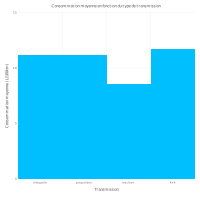

In [55]:
# Histogramme de la consommation moyenne en fonction du type de transmission
set_default_plot_size(20cm, 20cm)

mean_consommation = combine(groupby(data, :transmission), :consommation => mean => :mean_consommation)
# moyenne par type de transmission
println(mean_consommation)

Gadfly.plot(
    mean_consommation,
    x=:transmission,
    y=:mean_consommation,
    Geom.bar,
    Guide.xlabel("Transmission"),
    Guide.ylabel("Consommation moyenne (L/100km)"),
    Guide.title("Consommation moyenne en fonction du type de transmission")
)

Comme, les prédictions risquent d'être biaisées vers des valeurs associées aux classes majoritaires ("integrale" ou "traction"), nous pourrions poser l'hypothèse que le modèle risque de sous-estimer non seulement la consommation des véhicules avec une transmission 4x4 et propulsion, mais aussi les prédictions globales en raison de la forte représentation de la transmission traction. (Voir histogramme de la consommation par type de transmission). Pour pallier à ce problème, nous pourrions envisager de pondérer ou de regrouper les classes de transmission pour équilibrer les données. Par exemple, nous pourrions ajouter un poids élevé à la classe "4x4" et un poids plus faible à la classe "Traction" pour compenser leur représentation respective. Nous pourrions également regrouper les classes "Intégrale" et "Propulsion" en une seule catégorie pour augmenter leur représentation dans l'ensemble de données, si leur distinction n'apporte pas de valeur ajoutée au modèle.

Modèle de régression linéaire de base

In [117]:
full_train = CSV.read("../data/raw/train.csv", DataFrame; delim=";")
test =  CSV.read("../data/raw/test.csv", DataFrame; delim=";") #ne contient pas la varialbe consommation

Random.seed!(1234) #pour la reproductibilit

ntrain = round(Int, .8*nrow(full_train)) #80% des données pour l'entrainement: 80% * nb de lignes

train_id = sample(1:nrow(full_train), ntrain, replace=false, ordered=true) #échantillonnage aléatoire pour l'entrainement
valid_id = setdiff(1:nrow(full_train), train_id) #échantillon de validation. prend celles qui ne sont pas dans l'échantillon d'entrainement

train = full_train[train_id, :]  
valid = full_train[valid_id, :]

Row,annee,type,nombre_cylindres,cylindree,transmission,boite,consommation
,Int64,String31,Int64,String3,String15,String15,String31
1,2024,voiture_moyenne,8,"4,4",integrale,automatique,"12,3794736842105"
2,2024,voiture_sous_compacte,6,3,propulsion,automatique,"9,80041666666667"
3,2021,voiture_deux_places,6,3,propulsion,automatique,"10,6913636363636"
4,2018,voiture_compacte,4,2,propulsion,manuelle,"9,4084"
5,2015,VUS_standard,8,"6,2",4x4,automatique,"14,700625"
6,2021,VUS_petit,4,2,traction,automatique,"7,58741935483871"
7,2018,voiture_sous_compacte,4,2,integrale,manuelle,"8,71148148148148"
8,2014,VUS_standard,8,"4,8",integrale,automatique,"13,8358823529412"
9,2022,voiture_sous_compacte,8,"4,4",integrale,automatique,"12,3794736842105"


In [118]:
default_prerocessing(train)
default_prerocessing(valid)

In [119]:
# Define categorical columns
categorical_cols = [:transmission]

# Collect unique levels from the training set
levels_dict = Dict()
for col in categorical_cols
    levels_dict[col] = unique(train[!, col])
end

train = one_hot_encode(train, categorical_cols, levels_dict)
valid = one_hot_encode(valid, categorical_cols, levels_dict)

Row,annee,type,nombre_cylindres,cylindree,boite,consommation,transmission_integrale,transmission_propulsion,transmission_traction,transmission_4x4
,Int64,String31,Int64,Float64,String15,Float64,Float64,Float64,Float64,Float64
1,2024,voiture_moyenne,8,4.4,automatique,12.3795,1.0,0.0,0.0,0.0
2,2024,voiture_sous_compacte,6,3.0,automatique,9.80042,0.0,1.0,0.0,0.0
3,2021,voiture_deux_places,6,3.0,automatique,10.6914,0.0,1.0,0.0,0.0
4,2018,voiture_compacte,4,2.0,manuelle,9.4084,0.0,1.0,0.0,0.0
5,2015,VUS_standard,8,6.2,automatique,14.7006,0.0,0.0,0.0,1.0
6,2021,VUS_petit,4,2.0,automatique,7.58742,0.0,0.0,1.0,0.0
7,2018,voiture_sous_compacte,4,2.0,manuelle,8.71148,1.0,0.0,0.0,0.0
8,2014,VUS_standard,8,4.8,automatique,13.8359,1.0,0.0,0.0,0.0
9,2022,voiture_sous_compacte,8,4.4,automatique,12.3795,1.0,0.0,0.0,0.0


In [ ]:
model = lm(@formula(consommation ~  transmission_integrale + transmission_traction + transmission_propulsion), train) #Me

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

consommation ~ 1 + transmission_integrale + transmission_traction + transmission_propulsion + transmission_4x4

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────
                             Coef.  Std. Error       t  Pr(>|t|)  Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────────────────
(Intercept)              11.7382      0.412623   28.45    <1e-88   10.9264    12.5501
transmission_integrale   -0.591594    0.441113   -1.34    0.1808   -1.45952    0.276327
transmission_traction    -3.17723     0.445105   -7.14    <1e-11   -4.05301   -2.30145
transmission_propulsion  -0.557457    0.467871   -1.19    0.2344   -1.47803    0.363113
transmission_4x4          0.0       NaN         NaN       NaN     NaN        NaN
─

In [120]:
# Prediction avec l'ensemble de validation
valid_prediction = GLM.predict(modelA, valid)
train_prediction = GLM.predict(modelA, train)
# Trouver la moyenne de prediction
mean_prediction = mean(valid_prediction)
mean_prediction_train = mean(train_prediction)
# Remplacer les missing par la moyenne
valid_prediction = coalesce.(valid_prediction, mean_prediction)
train_prediction = coalesce.(train_prediction, mean_prediction_train)

# Calculer le RMSE
rmse_valid = sqrt(mean((valid_prediction - valid.consommation).^2))
rmse_train = sqrt(mean((train_prediction - train.consommation).^2))
println("RMSE train: ", rmse_train)
println("RMSE valid: ", rmse_valid)

RMSE train: 1.73953245783921
RMSE valid: 1.7000221273390825


###### Approche A: Ajustement de poids

In [121]:
full_train = CSV.read("../data/raw/train.csv", DataFrame; delim=";")
test =  CSV.read("../data/raw/test.csv", DataFrame; delim=";") #ne contient pas la varialbe consommation

Random.seed!(1234) #pour la reproductibilit

ntrain = round(Int, .8*nrow(full_train)) #80% des données pour l'entrainement: 80% * nb de lignes

train_id = sample(1:nrow(full_train), ntrain, replace=false, ordered=true) #échantillonnage aléatoire pour l'entrainement
valid_id = setdiff(1:nrow(full_train), train_id) #échantillon de validation. prend celles qui ne sont pas dans l'échantillon d'entrainement

train = full_train[train_id, :]  
valid = full_train[valid_id, :]

Row,annee,type,nombre_cylindres,cylindree,transmission,boite,consommation
,Int64,String31,Int64,String3,String15,String15,String31
1,2024,voiture_moyenne,8,"4,4",integrale,automatique,"12,3794736842105"
2,2024,voiture_sous_compacte,6,3,propulsion,automatique,"9,80041666666667"
3,2021,voiture_deux_places,6,3,propulsion,automatique,"10,6913636363636"
4,2018,voiture_compacte,4,2,propulsion,manuelle,"9,4084"
5,2015,VUS_standard,8,"6,2",4x4,automatique,"14,700625"
6,2021,VUS_petit,4,2,traction,automatique,"7,58741935483871"
7,2018,voiture_sous_compacte,4,2,integrale,manuelle,"8,71148148148148"
8,2014,VUS_standard,8,"4,8",integrale,automatique,"13,8358823529412"
9,2022,voiture_sous_compacte,8,"4,4",integrale,automatique,"12,3794736842105"


In [122]:
default_prerocessing(train)
default_prerocessing(valid)

In [123]:
counts = combine(groupby(train, :transmission), nrow => :nrow)

# Step 2: Calculate total number of observations and number of classes
total_samples = sum(counts.nrow)
num_classes = nrow(counts)

# Step 3: Compute weights for each transmission type
counts.Weight = total_samples ./ (num_classes .* counts.nrow)

# Step 4: Merge weights back into the original DataFrame
train = leftjoin(train, counts[:, [:transmission, :Weight]], on=:transmission)

Row,annee,type,nombre_cylindres,cylindree,transmission,boite,consommation,Weight
,Int64,String31,Int64,Float64,String15,String15,Float64,Float64?
1,2023,voiture_moyenne,8,4.4,integrale,automatique,13.8359,0.628968
2,2020,VUS_petit,4,2.0,integrale,automatique,9.80042,0.628968
3,2021,voiture_compacte,6,3.3,propulsion,automatique,11.7605,1.25794
4,2023,voiture_deux_places,8,5.0,integrale,automatique,13.0672,0.628968
5,2022,voiture_moyenne,8,4.4,integrale,automatique,13.8359,0.628968
6,2022,voiture_moyenne,8,4.4,integrale,automatique,13.8359,0.628968
7,2022,voiture_minicompacte,3,1.5,traction,automatique,7.35031,0.720455
8,2024,voiture_minicompacte,3,1.5,traction,manuelle,7.58742,0.720455
9,2020,VUS_standard,6,3.8,integrale,automatique,11.2005,0.628968


In [124]:
# Define categorical columns
categorical_cols = [:transmission]

# Collect unique levels from the training set
levels_dict = Dict()
for col in categorical_cols
    levels_dict[col] = unique(train[!, col])
end

train = one_hot_encode(train, categorical_cols, levels_dict)
valid = one_hot_encode(valid, categorical_cols, levels_dict)

Row,annee,type,nombre_cylindres,cylindree,boite,consommation,transmission_integrale,transmission_propulsion,transmission_traction,transmission_4x4
,Int64,String31,Int64,Float64,String15,Float64,Float64,Float64,Float64,Float64
1,2024,voiture_moyenne,8,4.4,automatique,12.3795,1.0,0.0,0.0,0.0
2,2024,voiture_sous_compacte,6,3.0,automatique,9.80042,0.0,1.0,0.0,0.0
3,2021,voiture_deux_places,6,3.0,automatique,10.6914,0.0,1.0,0.0,0.0
4,2018,voiture_compacte,4,2.0,manuelle,9.4084,0.0,1.0,0.0,0.0
5,2015,VUS_standard,8,6.2,automatique,14.7006,0.0,0.0,0.0,1.0
6,2021,VUS_petit,4,2.0,automatique,7.58742,0.0,0.0,1.0,0.0
7,2018,voiture_sous_compacte,4,2.0,manuelle,8.71148,1.0,0.0,0.0,0.0
8,2014,VUS_standard,8,4.8,automatique,13.8359,1.0,0.0,0.0,0.0
9,2022,voiture_sous_compacte,8,4.4,automatique,12.3795,1.0,0.0,0.0,0.0


In [125]:
# Ajuster le modèle avec les poids
train = dropmissing(train)

modelA = fit(LinearModel, @formula(consommation ~ transmission_propulsion + transmission_traction + transmission_integrale + transmission_4x4), train, wts = train.Weight)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

consommation ~ 1 + transmission_propulsion + transmission_traction + transmission_integrale + transmission_4x4

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────
                             Coef.  Std. Error       t  Pr(>|t|)  Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────────────
(Intercept)              11.7382      0.206771   56.77    <1e-99   11.3314    12.1451
transmission_propulsion  -0.557457    0.292419   -1.91    0.0575   -1.13281    0.0178981
transmission_traction    -3.17723     0.292419  -10.87    <1e-22   -3.75258   -2.60188
transmission_integrale   -0.591594    0.292419   -2.02    0.0439   -1.16695   -0.0162393
transmission_4x4          0.0       NaN         NaN       NaN     NaN        

In [126]:
# Prediction avec l'ensemble de validation
valid_prediction = GLM.predict(modelA, valid)
train_prediction = GLM.predict(modelA, train)
# Trouver la moyenne de prediction
mean_prediction = mean(valid_prediction)
mean_prediction_train = mean(train_prediction)
# Remplacer les missing par la moyenne
valid_prediction = coalesce.(valid_prediction, mean_prediction)
train_prediction = coalesce.(train_prediction, mean_prediction_train)

# Calculer le RMSE
rmse_valid = sqrt(mean((valid_prediction - valid.consommation).^2))
rmse_train = sqrt(mean((train_prediction - train.consommation).^2))
println("RMSE train: ", rmse_train)
println("RMSE valid: ", rmse_valid)

RMSE train: 1.73953245783921
RMSE valid: 1.7000221273390825


###### Approche B: Combinaison de catégories similaires 

Nous devons tester la significativité statistique de la différence entre les moyennes des catégories de transmission. Pour ce faire, nous avons effectué un test de student pour comparer les moyennes de consommation d'essence entre les différentes catégories de transmission. Ce test ne dicte qu'il faut regrouper de manière absolue, mais dans le cas où les moyennes sont significativement différentes, cela pourrait être une bonne idée de regrouper les catégories pour réduire le nombre de variables explicatives et potentiellement améliorer les prédictions.

In [18]:
full_train = CSV.read("../data/raw/train.csv", DataFrame; delim=";")
test =  CSV.read("../data/raw/test.csv", DataFrame; delim=";") #ne contient pas la varialbe consommation

Random.seed!(1234) #pour la reproductibilit

ntrain = round(Int, .8*nrow(full_train)) #80% des données pour l'entrainement: 80% * nb de lignes

train_id = sample(1:nrow(full_train), ntrain, replace=false, ordered=true) #échantillonnage aléatoire pour l'entrainement
valid_id = setdiff(1:nrow(full_train), train_id) #échantillon de validation. prend celles qui ne sont pas dans l'échantillon d'entrainement

train = full_train[train_id, :]  
valid = full_train[valid_id, :]

Row,annee,type,nombre_cylindres,cylindree,transmission,boite,consommation
,Int64,String31,Int64,String3,String15,String15,String31
1,2024,voiture_moyenne,8,"4,4",integrale,automatique,"12,3794736842105"
2,2024,voiture_sous_compacte,6,3,propulsion,automatique,"9,80041666666667"
3,2021,voiture_deux_places,6,3,propulsion,automatique,"10,6913636363636"
4,2018,voiture_compacte,4,2,propulsion,manuelle,"9,4084"
5,2015,VUS_standard,8,"6,2",4x4,automatique,"14,700625"
6,2021,VUS_petit,4,2,traction,automatique,"7,58741935483871"
7,2018,voiture_sous_compacte,4,2,integrale,manuelle,"8,71148148148148"
8,2014,VUS_standard,8,"4,8",integrale,automatique,"13,8358823529412"
9,2022,voiture_sous_compacte,8,"4,4",integrale,automatique,"12,3794736842105"


In [19]:
default_prerocessing(train)
default_prerocessing(valid)

In [20]:
# Fonction pour calculer la moyenne

function t_test_equal_variances(group1, group2)
    # Tailles des échantillons
    n1 = length(group1)
    n2 = length(group2)

    # Moyennes des deux groupes
    μ1 = mean(group1)
    μ2 = mean(group2)

    # Variances des deux groupes
    s1² = var(group1)
    s2² = var(group2)

    # Variance combinée pondérée
    sp² = ((n1 - 1) * s1² + (n2 - 1) * s2²) / (n1 + n2 - 2)

    # Statistique t
    t_stat = (μ1 - μ2) / sqrt(sp² * (1 / n1 + 1 / n2))

    # Degrés de liberté
    df = n1 + n2 - 2

    # p-valeur approximative (bilatérale) avec la loi de Student
    # Approximation pour t-distribution : 2 * (1 - cdf(gaussian, abs(t_stat)))
    # ou intégrer avec des librairies de tables t pour une solution complète.
    return t_stat, df
end

t_test_equal_variances (generic function with 1 method)

In [ ]:
group_integrale = train[train.transmission .== "integrale", :consommation]
group_4x4 = train[train.transmission .== "4x4", :consommation]
group_propulsion = train[train.transmission .== "propulsion", :consommation]


t_stat1, df1 = t_test_equal_variances(group_integrale, group_4x4)
t_stat2, df2 = t_test_equal_variances(group_integrale, group_propulsion)

absolut_t_stat1 = abs(t_stat1)
absolut_t_stat2 = abs(t_stat2)

pvalue1 = 2 * (1 - cdf(TDist(df1), absolut_t_stat1))
pvalue2 = 2 * (1 - cdf(TDist(df2), absolut_t_stat2))

println("----Goupe integrale-4x4----")
println("Statistique t: $absolut_t_stat1")
println("p-valeur  : $pvalue1")
println("Degrés de liberté : $df1")
println("----Goupe integrale-propulsion----")
println("Statistique t: $absolut_t_stat2")
println("p-valeur  : $pvalue2")
println("Degrés de liberté : $df2")

----Goupe integrale-4x4----
Statistique t: 1.2175082688830074
p-valeur  : 0.22543026080829454
Degrés de liberté : 142
----Goupe integrale-propulsion----
Statistique t: 0.11887578179731126
p-valeur  : 0.9055013724420791
Degrés de liberté : 187


Comme le test de student nous donne une p-value > 0.05, nous ne pouvons pas rejeter l'hypothèse nulle selon laquelle les moyennes de consommation d'essence entre les différentes catégories de transmission sont égales. Cela signifie que les différences de consommation d'essence entre les catégories de transmission (integralle-4x4 et integrale-propulsion) ne sont pas statistiquement significatives. Par conséquent, nous pourrions regrouper les catégories de transmission similaires pour augmenter leur représentation dans l'ensemble de données et potentiellement améliorer les prédictions. Certains tests devront être effectués pour déterminer si cette modification améliore réellement les prédictions.	

In [27]:
# Create a new column with the grouped categories
# if transmission is 4x4, change for integrale
train.transmission = ifelse.(train.transmission .== "4x4", "integrale", train.transmission)
valid.transmission = ifelse.(valid.transmission .== "4x4", "integrale", valid.transmission)

79-element Vector{AbstractString}:
 "integrale"
 "propulsion"
 "propulsion"
 "propulsion"
 "integrale"
 "traction"
 "integrale"
 "integrale"
 "integrale"
 "integrale"
 ⋮
 "traction"
 "traction"
 "integrale"
 "propulsion"
 "integrale"
 "propulsion"
 "integrale"
 "integrale"
 "propulsion"

In [28]:
train.transmission = ifelse.(train.transmission .== "propulsion", "integrale", train.transmission)
valid.transmission = ifelse.(valid.transmission .== "propulsion", "integrale", valid.transmission)

79-element Vector{AbstractString}:
 "integrale"
 "integrale"
 "integrale"
 "integrale"
 "integrale"
 "traction"
 "integrale"
 "integrale"
 "integrale"
 "integrale"
 ⋮
 "traction"
 "traction"
 "integrale"
 "integrale"
 "integrale"
 "integrale"
 "integrale"
 "integrale"
 "integrale"

In [30]:
# Define categorical columns
categorical_cols = [:transmission]

# Collect unique levels from the training set
levels_dict = Dict()
for col in categorical_cols
    levels_dict[col] = unique(train[!, col])
end

train = one_hot_encode(train, categorical_cols, levels_dict)
valid = one_hot_encode(valid, categorical_cols, levels_dict)

println(names(train))

["annee", "type", "nombre_cylindres", "cylindree", "boite", "consommation", "transmission_integrale", "transmission_traction"]


In [34]:
modelB = lm(@formula(consommation ~ transmission_integrale + transmission_traction), train)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

consommation ~ 1 + transmission_integrale + transmission_traction

Coefficients:
──────────────────────────────────────────────────────────────────────────────────
                          Coef.  Std. Error     t  Pr(>|t|)   Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────────────
(Intercept)             7.56099   5.19879e6  0.00    1.0000  -1.02289e7  1.02289e7
transmission_integrale  3.64747   5.19879e6  0.00    1.0000  -1.02289e7  1.02289e7
transmission_traction   1.0       5.19879e6  0.00    1.0000  -1.02289e7  1.02289e7
──────────────────────────────────────────────────────────────────────────────────

In [35]:
# Prediction avec l'ensemble de validation
train_prediction = GLM.predict(modelB, train)
valid_prediction = GLM.predict(modelB, valid)

# # Trouver la moyenne de prediction
# mean_prediction = mean(valid_prediction)
# mean_prediction_train = mean(train_prediction)
# # Remplacer les missing par la moyenne
# valid_prediction = coalesce.(valid_prediction, mean_prediction)
# train_prediction = coalesce.(train_prediction, mean_prediction_train)

# Calculer le RMSE
rmse_valid = sqrt(mean((valid_prediction - valid.consommation).^2))
rmse_train = sqrt(mean((train_prediction - train.consommation).^2))
println("RMSE train: ", rmse_train)
println("RMSE valid: ", rmse_valid)

RMSE train: 1.7445862163485437
RMSE valid: 1.7045835001556018


#### Corrélation entre les variables

In [ ]:
numeric_cols = [:annee, :nombre_cylindres, :cylindree, :consommation]

M = cor(Matrix(data[:, numeric_cols]))

# Afficher la matrice de corrélation
println("Matrice de corrélation :")
println(M)

# PLOT
(n,m) = size(M)
heatmap(M, fc=cgrad([:white,:dodgerblue4]), xticks=(1:m,numeric_cols), xrot=90, yticks=(1:m,numeric_cols), yflip=true)
annotate!([(j, i, text(round(M[i,j],digits=3), 8,"Computer Modern",:black)) for i in 1:n for j in 1:m])

1. `nombre_cylindres` et `cylindree` est très élevée, ce qui indique une forte relation positive. Cela suggère que le nombre de cylindres est fortement associé à la cylindrée des véhicules.

2. La corrélation entre `cylindree` et `consommation` est également élevée, montrant qu'une augmentation de la cylindrée est associée à une augmentation de la consommation (par exemple, les moteurs plus gros consomment plus de carburant).

3. Une corrélation similaire existe entre `nombre_cylindres` et `consommation`, ce qui est logique, car le nombre de cylindres et la cylindrée sont liés.

4. Les corrélations entre annee et les autres variables sont faibles et négatives, indiquant que les variables comme le nombre de cylindres, la cylindrée et la consommation ont légèrement diminué avec le temps.

# 4. Régression linéaire

In [ ]:
full_train = CSV.read("../data/raw/train.csv", DataFrame; delim=";")
test =  CSV.read("../data/raw/test.csv", DataFrame; delim=";") #ne contient pas la varialbe consommation

Random.seed!(1234) #pour la reproductibilit

ntrain = round(Int, .8*nrow(full_train)) #80% des données pour l'entrainement: 80% * nb de lignes

train_id = sample(1:nrow(full_train), ntrain, replace=false, ordered=true) #échantillonnage aléatoire pour l'entrainement
valid_id = setdiff(1:nrow(full_train), train_id) #échantillon de validation. prend celles qui ne sont pas dans l'échantillon d'entrainement

train = full_train[train_id, :]  
valid = full_train[valid_id, :]


In [ ]:
# capacite_moteur = :nombre_cylindres * :cylindree

In [ ]:
## convert annee column into age
train.age = 2024 .- train.annee
valid.age = 2024 .- valid.annee
test.age = 2024 .- test.annee

train = select!(train, Not(:annee))
valid = select!(valid, Not(:annee))
test = select!(test, Not(:annee))

## drop missing values
train = dropmissing(train)
valid = dropmissing(valid)
test = dropmissing(test)

In [ ]:
#Prétraitement

# Datasets that contain 'consommation'
datasets_with_consommation = [train, valid]

# Datasets without 'consommation'
datasets_without_consommation = [test]

# Apply replacements to 'cylindree' in all datasets
for df in [train, valid, test]
    df.cylindree = replace.(df.cylindree, "," => ".")
end

# Apply replacements to 'consommation' only in datasets that have it
for df in datasets_with_consommation
    df.consommation = replace.(df.consommation, "," => ".")
end

# Convert 'cylindree' to float in all datasets
for df in [train, valid, test]
    df.cylindree = safe_parse_float.(df.cylindree)
end

# Convert 'consommation' to float in datasets with 'consommation'
for df in datasets_with_consommation
    df.consommation = safe_parse_float.(df.consommation)
end

# Drop missing values in all datasets
for df in [train, valid, test]
    dropmissing!(df)
end

# # Encode 'boite' column in all datasets
for df in [train, valid, test]
    df.boite = ifelse.(df.boite .== "automatique", 1.0, 0.0)
end


In [ ]:
# # Create a new column with the grouped categories
# # if transmission is 4x4, change for integrale
# train.transmission = ifelse.(train.transmission .== "4x4", "integrale", train.transmission)
# train.transmission = ifelse.(train.transmission .== "4x4", "integrale", train.transmission)

In [ ]:
# Define categorical columns
categorical_cols = [:type, :transmission, :boite]

# Collect unique levels from the training set
levels_dict = Dict()
for col in categorical_cols
    levels_dict[col] = unique(train[!, col])
end

train = one_hot_encode(train, categorical_cols, levels_dict)
valid = one_hot_encode(valid, categorical_cols, levels_dict)
test = one_hot_encode(test, categorical_cols, levels_dict)

In [ ]:
# normalize the data
function standardizer(X, means, stds)
    X = deepcopy(X)
    for j in 1:size(X, 2)
        if j in numeric_indices
            X[:, j] = (X[:, j] .- means[j]) ./ stds[j]
        end
    end
    return X
end

# cols_to_normalize = [:age, :capacite_moteur]

# means = [mean(train[!, col]) for col in cols_to_normalize]
# stds = [std(train[!, col]) for col in cols_to_normalize]

# train[!, cols_to_normalize] = standardizer(Matrix(train[!, cols_to_normalize]), means, stds)
# valid[!, cols_to_normalize] = standardizer(Matrix(valid[!, cols_to_normalize]), means, stds)


In [ ]:
# print every column in the dataframe

rename!(train, "boite_0.0" => "boite_0", "boite_1.0" => "boite_1")
rename!(valid, "boite_0.0" => "boite_0", "boite_1.0" => "boite_1")


for col in names(train)
    println(col)
end


In [ ]:
using GLM

# Define all formulas for models
model_formulas = [
    @formula(consommation ~ age),
    @formula(consommation ~ age + nombre_cylindres),
    @formula(consommation ~ age + cylindree),
    @formula(consommation ~ age + nombre_cylindres + cylindree ),
    @formula(consommation ~ age + transmission_integrale),
    @formula(consommation ~ age + transmission_integrale + transmission_propulsion + transmission_traction + transmission_4x4 + nombre_cylindres),
    @formula(consommation ~ age + transmission_integrale + transmission_propulsion + transmission_traction + transmission_4x4 + cylindree),
    @formula(consommation ~ age + transmission_integrale + transmission_propulsion + transmission_traction + transmission_4x4 + cylindree + nombre_cylindres),
    @formula(consommation ~ nombre_cylindres + cylindree + age + 
    type_voiture_moyenne + type_VUS_petit + type_voiture_compacte + type_voiture_deux_places + type_voiture_minicompacte +
    type_VUS_standard + type_voiture_sous_compacte + type_break_petit + type_voiture_grande + type_camionnette_standard +
    transmission_integrale + transmission_propulsion + transmission_traction + transmission_4x4 + boite_0 + boite_1),
    @formula(consommation ~ age + transmission_integrale + transmission_propulsion + transmission_traction + transmission_4x4 + cylindree + type_voiture_moyenne + type_VUS_petit + type_voiture_compacte + type_voiture_deux_places + type_voiture_minicompacte +
    type_VUS_standard + type_voiture_sous_compacte + type_break_petit + type_voiture_grande + type_camionnette_standard),
    @formula(consommation ~ age + cylindree + type_voiture_moyenne + type_VUS_petit + type_voiture_compacte + type_voiture_deux_places + type_voiture_minicompacte +
    type_VUS_standard + type_voiture_sous_compacte + type_break_petit + type_voiture_grande + type_camionnette_standard)
]

# Fit each model and calculate BIC
# Fit models and calculate BIC
models = []
bics = []
rmses = []
for formula in model_formulas
    model = lm(formula, train)
    push!(models, model)
    push!(bics, GLM.bic(model))
    
    # Calculate RMSE on validation set
    valid_prediction = GLM.predict(model, valid)
    rmse = sqrt(mean((valid_prediction - valid.consommation).^2))
    push!(rmses, rmse)
end

# Find the best model by BIC and RMSE
best_bic_index = argmin(bics)
best_rmse_index = argmin(rmses)

println("Best Model by BIC: ", model_formulas[best_bic_index])
println("BIC: ", bics[best_bic_index])
println("Best Model by RMSE: ", model_formulas[best_rmse_index])
println("RMSE: ", rmses[best_rmse_index])



In [ ]:
model = lm(@formula(consommation ~ age + transmission_integrale + transmission_propulsion + transmission_traction + transmission_4x4 + cylindree), train)
#model = lm(@formula(consommation ~ age + transmission_integrale + transmission_propulsion + transmission_traction + transmission_4x4 + nombre_cylindres), train)

In [ ]:
# Prediction avec l'ensemble de validation
valid_prediction = GLM.predict(model, valid)
# Trouver la moyenne de prediction
mean_prediction = mean(valid_prediction)
# Remplacer les missing par la moyenne
#valid_prediction = coalesce.(valid_prediction, mean_prediction)
# Transformer les predictions en valeur entiere
#v = Int.(round.(valid_prediction, digits=0)) #mettre une commentaire sur la difference que ca entraine sur le rmse
# Calculer le RMSE
rmse_valid = sqrt(mean((valid_prediction - valid.consommation).^2))
println("RMSE: ", rmse_valid)

In [ ]:
n = nrow(test)

id = 1:n

ŷ = GLM.predict(model, test)

df_pred = DataFrame(id=id, consommation=ŷ)

name = "linear/" * string(rmse_valid) * ".csv"
CSV.write("../submissions/" * name, df_pred)
println("Predictions exported successfully to " * name*".")

In [ ]:
using CSV, DataFrames, Statistics, Dates, Gadfly, Combinatorics, Plots, StatsBase, StatsPlots, Random, StatsModels, GLM, LinearAlgebra, MultivariateStats, Distributions

full_train = CSV.read("../data/raw/train.csv", DataFrame; delim=";")
test =  CSV.read("../data/raw/test.csv", DataFrame; delim=";") #ne contient pas la varialbe consommation

Random.seed!(1234) #pour la reproductibilit

ntrain = round(Int, .8*nrow(full_train)) #80% des données pour l'entrainement: 80% * nb de lignes

train_id = sample(1:nrow(full_train), ntrain, replace=false, ordered=true) #échantillonnage aléatoire pour l'entrainement
valid_id = setdiff(1:nrow(full_train), train_id) #échantillon de validation. prend celles qui ne sont pas dans l'échantillon d'entrainement

train = full_train[train_id, :]  
valid = full_train[valid_id, :]

function safe_parse_float(x)
    try
        return parse(Float64, x)
    catch
        return missing
    end
end

function one_hot_encode(df, cols, levels_dict)
    for col in cols
        levels_col = levels_dict[col]
        for level in levels_col
            new_col = Symbol(string(col) * "_" * string(level))
            df[!, new_col] = ifelse.(df[!, col] .== level, 1.0, 0.0)
        end
        select!(df, Not(col))
    end
    return df
end

# ## convert annee column into age
# train.age = 2024 .- train.annee
# valid.age = 2024 .- valid.annee
# test.age = 2024 .- test.annee

# train = select!(train, Not(:annee))
# valid = select!(valid, Not(:annee))
# test = select!(test, Not(:annee))

## drop missing values
train = dropmissing(train)
valid = dropmissing(valid)
test = dropmissing(test)

# Datasets that contain 'consommation'
datasets_with_consommation = [train, valid]

# Datasets without 'consommation'
datasets_without_consommation = [test]

# Apply replacements to 'cylindree' in all datasets
for df in [train, valid, test]
    df.cylindree = replace.(df.cylindree, "," => ".")
end

# Apply replacements to 'consommation' only in datasets that have it
for df in datasets_with_consommation
    df.consommation = replace.(df.consommation, "," => ".")
end

# Convert 'cylindree' to float in all datasets
for df in [train, valid, test]
    df.cylindree = safe_parse_float.(df.cylindree)
end

# Convert 'consommation' to float in datasets with 'consommation'
for df in datasets_with_consommation
    df.consommation = safe_parse_float.(df.consommation)
end

# Drop missing values in all datasets
for df in [train, valid, test]
    dropmissing!(df)
end

# Encode 'boite' column in all datasets
for df in [train, valid, test]
    df.boite = ifelse.(df.boite .== "automatique", 1.0, 0.0)
end

# train.cylindree = log.(train.cylindree .+ 1)
# valid.cylindree = log.(valid.cylindree.+ 1)
# test.cylindree = log.(test.cylindree.+ 1)

function remove_outliers_by_iqr(df, group_col, value_col)
    return combine(groupby(df, group_col)) do sdf
        q1 = quantile(sdf[!, value_col], 0.25)
        q3 = quantile(sdf[!, value_col], 0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        filter(row -> lower_bound ≤ row[value_col] ≤ upper_bound, sdf)
    end
end
#Remove outliers in the training set
train = remove_outliers_by_iqr(train, :cylindree, :consommation)
valid = remove_outliers_by_iqr(valid, :cylindree, :consommation)

# if transmission is 4x4, change for integrale
train.transmission = ifelse.(train.transmission .== "4x4", "integrale", train.transmission)
valid.transmission = ifelse.(valid.transmission .== "4x4", "integrale", valid.transmission)
test.transmission = ifelse.(test.transmission .== "4x4", "integrale", test.transmission)

train.transmission = ifelse.(train.transmission .== "propulsion", "integrale", train.transmission)
valid.transmission = ifelse.(valid.transmission .== "propulsion", "integrale", valid.transmission)
test.transmission = ifelse.(test.transmission .== "propulsion", " integale", test.transmission)

# Define categorical columns
categorical_cols = [:type, :transmission]

# Collect unique levels from the training set
levels_dict = Dict()
for col in categorical_cols
    levels_dict[col] = unique(train[!, col])
end

#standardize the data
mean_train = mean(train[!, :cylindree])
std_train = std(train[!, :cylindree])

train[!, :cylindree] = (train[!, :cylindree] .- mean_train) ./ std_train
valid[!, :cylindree] = (valid[!, :cylindree] .- mean_train) ./ std_train
test[!, :cylindree] = (test[!, :cylindree] .- mean_train) ./ std_train

# mean_train = mean(train[!, :age])
# std_train = std(train[!, :age])

# train[!, :age] = (train[!, :age] .- mean_train) ./ std_train
# valid[!, :age] = (valid[!, :age] .- mean_train) ./ std_train
# test[!, :age] = (test[!, :age] .- mean_train) ./ std_train

mean_train = mean(train[!, :consommation])
std_train = std(train[!, :consommation])

train[!, :consommation] = (train[!, :consommation] .- mean_train) ./ std_train
valid[!, :consommation] = (valid[!, :consommation] .- mean_train) ./ std_train

train = one_hot_encode(train, categorical_cols, levels_dict)
valid = one_hot_encode(valid, categorical_cols, levels_dict)
test = one_hot_encode(test, categorical_cols, levels_dict)

# Define the target variable
target = :consommation

# Define the feature matrix and target vector
X_train = Matrix(train[:, Not([target])])
y_train = train[!, target]
X_valid = Matrix(valid[:, Not([target])])
y_valid = valid[!, target]
X_test = Matrix(test)

# Define the model
# model = lm(@formula(consommation ~ age + transmission_4x4+ transmission_integrale + transmission_propulsion + transmission_traction + boite + cylindree), train)
model = lm(@formula(consommation ~  transmission_integrale + transmission_traction + boite + cylindree), train) #Meilleur
# model = lm(@formula(consommation ~ age +  transmission_integrale + transmission_4x4 + transmission_traction + boite + cylindree), train)

#model information
println(model)

#cross validation
data_k_folds = vcat(train, valid)
y = data_k_folds.consommation
X = select(data_k_folds, Not(:consommation))

n = nrow(data_k_folds)
k = 5
fold_size = n ÷ k

indices = randperm(n)

rms_scores = []

for i in 0:(k-1)
    valid_indices = (i * fold_size + 1):((i + 1) * fold_size)
    train_indices = setdiff(1:n, valid_indices)
    
    X_train = X[train_indices, :]
    y_train = y[train_indices]
    X_valid = X[valid_indices, :]
    y_valid = y[valid_indices]
    
    df = DataFrame(X_train)
    df.consommation = y_train

 model = lm(@formula(consommation ~ transmission_traction + boite + cylindree), df) #Meilleur
    
    ŷ_valid = GLM.predict(model, X_valid)
    rms = sqrt(mean((ŷ_valid .- y_valid).^2))
    push!(rms_scores, rms)
end

moyenne_rmse = mean(rms_scores)
std_consommation = std(data_k_folds.consommation)

real_rmse = moyenne_rmse * std_train
println("Moyenne RMSE k-fold : $real_rmse")

# Make predictions
ŷ_train = GLM.predict(model, train)
ŷ_valid = GLM.predict(model, valid)

vif_values = vif(model)
println("VIF values: ", vif_values)

# Compute the RMSE
rmse_train = sqrt(mean((ŷ_train .- train.consommation).^2))
rmse_valid = sqrt(mean((ŷ_valid .- valid.consommation).^2))

#plot dirstribtuion of residuals
res = ŷ_valid .- valid.consommation
h = histogram(res, bins=50, title="Distribution of res", xlabel="res", ylabel="Frequency")
display(h)

# # extreme values
# extreme_values = valid[abs.(res) .> 2, [:cylindree, :consommation, :transmission_integrale, :transmission_traction, :boite]]
# println(extreme_values)

# # find the row with the highest residual
# max_residual_index = argmax(abs.(res))
# max_residual_row = valid[max_residual_index, :]
# println(max_residual_row)

println("RMSE train: ", rmse_train * std_train)
println("RMSE valid: ", rmse_valid * std_train)


scatter(train[!, :cylindree], res,
        xlabel="Cylindrée", ylabel="Résidus",
        title="Résidus vs Cylindrée")
println("mean res: ", mean(res))


# 5. Régression bayesienne

In [ ]:
## convert annee column into age
train.age = 2024 .- train.annee
valid.age = 2024 .- valid.annee
test.age = 2024 .- test.annee

train = select!(train, Not(:annee))
valid = select!(valid, Not(:annee))
test = select!(test, Not(:annee))

## drop missing values
train = dropmissing(train)
valid = dropmissing(valid)
test = dropmissing(test)

In [ ]:
# Datasets that contain 'consommation'
datasets_with_consommation = [train, valid]

# Datasets without 'consommation'
datasets_without_consommation = [test]

# Apply replacements to 'cylindree' in all datasets
for df in [train, valid, test]
    df.cylindree = replace.(df.cylindree, "," => ".")
end

# Apply replacements to 'consommation' only in datasets that have it
for df in datasets_with_consommation
    df.consommation = replace.(df.consommation, "," => ".")
end

# Convert 'cylindree' to float in all datasets
for df in [train, valid, test]
    df.cylindree = safe_parse_float.(df.cylindree)
end

# Convert 'consommation' to float in datasets with 'consommation'
for df in datasets_with_consommation
    df.consommation = safe_parse_float.(df.consommation)
end

# Drop missing values in all datasets
for df in [train, valid, test]
    dropmissing!(df)
end

# # Encode 'boite' column in all datasets
# for df in [train, valid, test]
#     df.boite = ifelse.(df.boite .== "automatique", 1.0, 0.0)
# end


In [ ]:
# Define categorical columns
categorical_cols = [:type, :transmission, :boite]

# Collect unique levels from the training set
levels_dict = Dict()
for col in categorical_cols
    levels_dict[col] = unique(train[!, col])
end

train = one_hot_encode(train, categorical_cols, levels_dict)
valid = one_hot_encode(valid, categorical_cols, levels_dict)
test = one_hot_encode(test, categorical_cols, levels_dict)

In [ ]:
y_train = train.consommation
X_train = select(train, Not(:consommation))
y_valid = valid.consommation
X_valid = select(valid, Not(:consommation))
X_test = deepcopy(test)


In [ ]:
# Identify numeric feature indices
feature_names = names(train)
numeric_features = [ :cylindree, :nombre_cylindres, :age]
numeric_indices = findall(x -> x in numeric_features, feature_names)

means = mean(Matrix(X_train[:, numeric_features]), dims=1)
stds = std(Matrix(X_train[:, numeric_features]), dims=1)

In [ ]:
function standardizer(X, means, stds)
    X = deepcopy(X)
    for j in 1:size(X, 2)
        if j in numeric_indices
            X[:, j] = (X[:, j] .- means[j]) ./ stds[j]
        end
    end
    return X
end

In [ ]:
X_train = standardizer(Matrix(X_train), means, stds)
X_valid = standardizer(Matrix(X_valid), means, stds)
X_test = standardizer(Matrix(X_test), means, stds)

y_train = Vector(y_train)
y_valid = Vector(y_valid)

In [ ]:
# Ridge regression with cross-validation
XtX = X_train' * X_train
Xty = X_train' * y_train
n_features = size(X_train, 2)

In [ ]:
describe(valid)

In [ ]:
lambda_values = 10 .^ range(-5, stop=5, length=1000)
best_rmse = Inf
best_lambda = 0.0
best_beta = nothing


for λ in lambda_values
    beta = (XtX + λ * I) \ Xty
    y_pred_valid = X_valid * beta
    rmse = sqrt(mean((y_pred_valid - y_valid).^2))
    if rmse < best_rmse
        best_rmse = rmse
        best_lambda = λ
        best_beta = beta
    end
end

println("Best Lambda: ", best_lambda)
println("Best RMSE: ", best_rmse)

In [ ]:
# # Evaluation on validation set
y_valid_pred = X_valid * best_beta
rmse_valid = sqrt(mean((y_valid_pred - y_valid).^2))
println("Validation RMSE: ", rmse_valid)

# Predictions on test set
y_test_pred = X_test * best_beta

# Prepare submission DataFrame
n_test = size(y_test_pred, 1)
id = 1:n_test
df_pred = DataFrame(id=id, consommation=y_test_pred)

name = "ridge" * string(rmse_valid) * ".csv"
CSV.write("../submissions/bayes/" * name, df_pred)
println("Predictions exported successfully to " * name*".")

# 6. Validation par k-fold cross-validation

In [ ]:
data_k_folds = vcat(train, valid)
y = data_k_folds.consommation
X = select(data_k_folds, Not(:consommation))

n = nrow(data_k_folds)
k = 5  
fold_size = n ÷ k

indices = randperm(n)

rms_scores = []

for i in 0:(k-1)
    test_indices = indices[(i*fold_size + 1):min((i+1)*fold_size, n)]
    train_indices = setdiff(indices, test_indices)
    
    train_data = data_k_folds[train_indices, :]
    test_data = data_k_folds[test_indices, :]
    
    model = lm(@formula(consommation ~ age  + transmission_integrale + transmission_propulsion + transmission_traction + transmission_4x4 + cylindree), data_k_folds)
 
    
    valid_prediction = GLM.predict(model, test_data)
    
    mean_prediction = mean(skipmissing(valid_prediction))
    valid_prediction = coalesce.(valid_prediction, mean_prediction)
    
    if any(ismissing, valid_prediction)
        error("Skip les valeur missing")
    end
    
    v = max.(valid_prediction, 0) 
    
    score = sqrt(mean((v - test_data.consommation).^2))
    push!(rms_scores, score)
end

moyenne_rmse = mean(rms_scores)
println("Moyenne RMSE : $moyenne_rmse")

In [ ]:
full_train = CSV.read("../data/raw/train.csv", DataFrame; delim=";")
test =  CSV.read("../data/raw/test.csv", DataFrame; delim=";") #ne contient pas la varialbe consommation

Random.seed!(1234) #pour la reproductibilit

ntrain = round(Int, .8*nrow(full_train)) #80% des données pour l'entrainement: 80% * nb de lignes

train_id = sample(1:nrow(full_train), ntrain, replace=false, ordered=true) #échantillonnage aléatoire pour l'entrainement
valid_id = setdiff(1:nrow(full_train), train_id) #échantillon de validation. prend celles qui ne sont pas dans l'échantillon d'entrainement

train = full_train[train_id, :]  
valid = full_train[valid_id, :]

using MultivariateStats
using GLM

# Data Cleaning and Preparation
Random.seed!(1234) # For reproducibility

# Split the data
ntrain = round(Int, 0.8 * nrow(full_train))
train_id = sample(1:nrow(full_train), ntrain; replace=false, ordered=true)
valid_id = setdiff(1:nrow(full_train), train_id)

train = full_train[train_id, :]
valid = full_train[valid_id, :]
train = full_train

# Data cleaning
for col in [:cylindree, :consommation]
    train[!, col] = replace.(train[!, col], "," => ".")
    valid[!, col] = replace.(valid[!, col], "," => ".")
    train[!, col] = safe_parse_float.(train[!, col])
    valid[!, col] = safe_parse_float.(valid[!, col])
end

for col in [:cylindree,]
    test[!, col] = replace.(test[!, col], "," => ".")
    test[!, col] = safe_parse_float.(test[!, col])
end

# Define categorical columns
categorical_cols = [:type, :transmission, :boite]

# Collect unique levels from the training set
# levels_dict = Dict()
# for col in categorical_cols
#     levels_dict[col] = unique(train[!, col])
# end

#train = one_hot_encode(train, categorical_cols, levels_dict)
#valid = one_hot_encode(valid, categorical_cols, levels_dict)
#test = one_hot_encode(test, categorical_cols, levels_dict)


In [ ]:
using Statistics
using Plots

# Extraire les variables continues
continuous_vars = train[:, [:cylindree, :nombre_cylindres, :consommation]]

# Convertir en matrice et calculer la corrélation
data_matrix = Matrix(continuous_vars)
correlation_matrix = cor(data_matrix)

# Afficher la matrice
println("Matrice de corrélation :")
println(correlation_matrix)

# Visualiser la matrice
heatmap(correlation_matrix,
    xticks = (1:size(correlation_matrix, 1), names(continuous_vars)),
    yticks = (1:size(correlation_matrix, 2), names(continuous_vars)),
    title = "Matrice de corrélation",
    color = :coolwarm
)

In [ ]:
using Statistics

# Calcul des moyennes de consommation par catégorie pour 'type'
mean_values = combine(groupby(train, :type), :consommation => mean => :mean_consommation)
println(mean_values)

In [ ]:
using StatsPlots

@df mean_values bar(:type, :mean_consommation, xlabel="Type de véhicule", ylabel="Consommation Moyenne", title="Consommation Moyenne par Type de Véhicule", legend=false, rotation=45)

In [ ]:
using Statistics

# Calcul des moyennes de consommation par catégorie pour 'type'
mean_values = combine(groupby(train, :transmission), :consommation => mean => :mean_consommation)
println(mean_values)

In [ ]:
using StatsPlots

@df mean_values bar(:transmission, :mean_consommation, xlabel="Type de véhicule", ylabel="Consommation Moyenne", title="Consommation Moyenne par transmission", legend=false, rotation=45)

In [ ]:
using Statistics

# Calcul des moyennes de consommation par catégorie pour 'type'
mean_values = combine(groupby(train, :boite), :consommation => mean => :mean_consommation)
println(mean_values)

In [ ]:
using StatsPlots

@df mean_values bar(:boite, :mean_consommation, xlabel="Type de véhicule", ylabel="Consommation Moyenne", title="Consommation Moyenne par boite", legend=false, rotation=45)

In [ ]:
using CategoricalArrays

train.categorie_vehicule = CategoricalArray{String}(undef, nrow(train))

for i in 1:nrow(train)
    if train.type[i] in ["break_petit", "voiture_minicompacte", "voiture_compacte", "VUS_petit", "voiture_moyenne"]
        train.categorie_vehicule[i] = "Petits Véhicules"
    elseif train.type[i] in ["voiture_sous_compacte", "break_moyen", "monospace", "camionnette_petit"]
        train.categorie_vehicule[i] = "Véhicules Moyens"
    else
        train.categorie_vehicule[i] = "Grands Véhicules"
    end
end

In [ ]:
using Pkg
Pkg.add("HypothesisTests")

using StatsModels, GLM, HypothesisTests

# Ajuster le modèle complet
model_full = lm(@formula(consommation ~ categorie_vehicule), train)

# Ajuster le modèle réduit
model_reduced = lm(@formula(consommation ~ 1), train)

# Effectuer le test F
ftest_result = ftest(model_full.model, model_reduced.model)
println(ftest_result)


In [ ]:
function categorize_vehicle_type(vehicle_type)
    if vehicle_type in ["break_petit", "voiture_minicompacte", "voiture_compacte", "VUS_petit", "voiture_moyenne"]
        return "petits_véhicules"
    elseif vehicle_type in ["voiture_sous_compacte", "break_moyen", "monospace", "camionnette_petit"]
        return "véhicules_moyens"
    else
        return "grands_véhicules"
    end
end


In [ ]:
function categorize_transmission(transmission)
    if transmission in ["integrale", "4x4", "propulsion"]
        return "AWD/RWD"
    else
        return "traction"
    end
end


In [ ]:
#Pour le DataFrame 'train'
train[:, :categorie_vehicule] = [categorize_vehicle_type(t) for t in train[:, :type]]

# Pour le DataFrame 'valid'
valid[:, :categorie_vehicule] = [categorize_vehicle_type(t) for t in valid[:, :type]]

# Pour le DataFrame 'test'
test[:, :categorie_vehicule] = [categorize_vehicle_type(t) for t in test[:, :type]]

In [ ]:
train[:, :categorie_transmission] = [categorize_transmission(t) for t in train[:, :transmission]]
valid[:, :categorie_transmission] = [categorize_transmission(t) for t in valid[:, :transmission]]
test[:, :categorie_transmission] = [categorize_transmission(t) for t in test[:, :transmission]]

In [ ]:
using DataFrames, Statistics

# Data cleaning
for col in [:consommation]
    train[!, col] = replace.(train[!, col], "," => ".")
    valid[!, col] = replace.(valid[!, col], "," => ".")
    train[!, col] = safe_parse_float.(train[!, col])
    valid[!, col] = safe_parse_float.(valid[!, col])
end

# Calculer la consommation moyenne par combinaison de categorie_vehicule et categorie_transmission
mean_consumption_interaction = combine(groupby(train, [:categorie_vehicule, :categorie_transmission]),
                                      :consommation => mean => :mean_consommation)

println(mean_consumption_interaction)


In [ ]:
using CSV, DataFrames, Statistics, Dates, Gadfly, Combinatorics, Plots, StatsBase, StatsPlots, Random, StatsModels, GLM, LinearAlgebra, MultivariateStats, Distributions

full_train = CSV.read("../data/raw/train.csv", DataFrame; delim=";")
test =  CSV.read("../data/raw/test.csv", DataFrame; delim=";") #ne contient pas la varialbe consommation

Random.seed!(1234) #pour la reproductibilit

ntrain = round(Int, .8*nrow(full_train)) #80% des données pour l'entrainement: 80% * nb de lignes

train_id = sample(1:nrow(full_train), ntrain, replace=false, ordered=true) #échantillonnage aléatoire pour l'entrainement
valid_id = setdiff(1:nrow(full_train), train_id) #échantillon de validation. prend celles qui ne sont pas dans l'échantillon d'entrainement

train = full_train[train_id, :]  
valid = full_train[valid_id, :]

function safe_parse_float(x)
    try
        return parse(Float64, x)
    catch
        return missing
    end
end

function one_hot_encode(df, cols, levels_dict)
    for col in cols
        levels_col = levels_dict[col]
        for level in levels_col
            new_col = Symbol(string(col) * "_" * string(level))
            df[!, new_col] = ifelse.(df[!, col] .== level, 1.0, 0.0)
        end
        select!(df, Not(col))
    end
    return df
end

## convert annee column into age
train.age = 2024 .- train.annee
valid.age = 2024 .- valid.annee
test.age = 2024 .- test.annee

train = select!(train, Not(:annee))
valid = select!(valid, Not(:annee))
test = select!(test, Not(:annee))

## drop missing values
train = dropmissing(train)
valid = dropmissing(valid)
test = dropmissing(test)

# Datasets that contain 'consommation'
datasets_with_consommation = [train, valid]

# Datasets without 'consommation'
datasets_without_consommation = [test]

# Apply replacements to 'cylindree' in all datasets
for df in [train, valid, test]
    df.cylindree = replace.(df.cylindree, "," => ".")
end

# Apply replacements to 'consommation' only in datasets that have it
for df in datasets_with_consommation
    df.consommation = replace.(df.consommation, "," => ".")
end

# Convert 'cylindree' to float in all datasets
for df in [train, valid, test]
    df.cylindree = safe_parse_float.(df.cylindree)
end

# Convert 'consommation' to float in datasets with 'consommation'
for df in datasets_with_consommation
    df.consommation = safe_parse_float.(df.consommation)
end

# Drop missing values in all datasets
for df in [train, valid, test]
    dropmissing!(df)
end

# Encode 'boite' column in all datasets
for df in [train, valid, test]
    df.boite = ifelse.(df.boite .== "automatique", 1.0, 0.0)
end

train.cylindree = log.(train.cylindree .+ 1)
valid.cylindree = log.(valid.cylindree.+ 1)
test.cylindree = log.(test.cylindree.+ 1)

function remove_outliers_by_iqr(df, group_col, value_col)
    return combine(groupby(df, group_col)) do sdf
        q1 = quantile(sdf[!, value_col], 0.25)
        q3 = quantile(sdf[!, value_col], 0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        filter(row -> lower_bound ≤ row[value_col] ≤ upper_bound, sdf)
    end
end
#Remove outliers in the training set
train = remove_outliers_by_iqr(train, :cylindree, :consommation)
valid = remove_outliers_by_iqr(valid, :cylindree, :consommation)

# # change type break_petit to voiture_minicompacte
# train.type = replace(train.type, "break_petit" => "voiture_minicompacte")
# valid.type = replace(valid.type, "break_petit" => "voiture_minicompacte")
# test.type = replace(test.type, "break_petit" => "voiture_minicompacte")

# if transmission is 4x4, change for integrale
# train.transmission = ifelse.(train.transmission .== "4x4", "integrale", train.transmission)
# valid.transmission = ifelse.(valid.transmission .== "4x4", "integrale", valid.transmission)
# test.transmission = ifelse.(test.transmission .== "4x4", "integrale", test.transmission)
function categorize_transmission(transmission)
    if transmission in ["integrale", "4x4", "propulsion"]
        return "AWDRWD"
    else
        return "traction"
    end
end

function categorize_vehicle_type(vehicle_type)
    if vehicle_type in ["break_petit", "voiture_minicompacte", "voiture_compacte", "VUS_petit", "voiture_moyenne"]
        return "petits_véhicules"
    elseif vehicle_type in ["voiture_sous_compacte", "break_moyen", "monospace", "camionnette_petit"]
        return "véhicules_moyens"
    else
        return "grands_véhicules"
    end
end



train[:, :categorie_transmission] = [categorize_transmission(t) for t in train[:, :transmission]]
valid[:, :categorie_transmission] = [categorize_transmission(t) for t in valid[:, :transmission]]
test[:, :categorie_transmission] = [categorize_transmission(t) for t in test[:, :transmission]]



train[:, :categorie_vehicule] = [categorize_vehicle_type(t) for t in train[:, :type]]
valid[:, :categorie_vehicule] = [categorize_vehicle_type(t) for t in valid[:, :type]]
test[:, :categorie_vehicule] = [categorize_vehicle_type(t) for t in test[:, :type]]


train = select!(train, Not(:transmission, :type))
valid = select!(valid, Not(:transmission, :type))
test = select!(test, Not(:transmission, :type))

# Define categorical columns
categorical_cols = [:categorie_vehicule, :categorie_transmission]

# Collect unique levels from the training set
levels_dict = Dict()
for col in categorical_cols
    levels_dict[col] = unique(train[!, col])
end

train = one_hot_encode(train, categorical_cols, levels_dict)
valid = one_hot_encode(valid, categorical_cols, levels_dict)
test = one_hot_encode(test, categorical_cols, levels_dict)


# Define the target variable
target = :consommation

# Define the feature matrix and target vector
X_train = Matrix(train[:, Not([target])])
y_train = train[!, target]
X_valid = Matrix(valid[:, Not([target])])
y_valid = valid[!, target]
X_test = Matrix(test)

# Create interaction terms
train.categorie_transmission_traction_vehicule_petits = train.categorie_transmission_traction .* train.categorie_vehicule_petits_véhicules
train.categorie_transmission_traction_vehicule_moyens = train.categorie_transmission_traction .* train.categorie_vehicule_véhicules_moyens

valid.categorie_transmission_traction_vehicule_petits = valid.categorie_transmission_traction .* valid.categorie_vehicule_petits_véhicules
valid.categorie_transmission_traction_vehicule_moyens = valid.categorie_transmission_traction .* valid.categorie_vehicule_véhicules_moyens

test.categorie_transmission_traction_vehicule_petits = test.categorie_transmission_traction .* test.categorie_vehicule_petits_véhicules
test.categorie_transmission_traction_vehicule_moyens = test.categorie_transmission_traction .* test.categorie_vehicule_véhicules_moyens


# Define the model
# model = lm(@formula(consommation ~ age + transmission_4x4+ transmission_integrale + transmission_propulsion + transmission_traction + boite + cylindree), train)
model = lm(@formula(consommation ~ age + categorie_transmission_traction + categorie_vehicule_petits_véhicules + categorie_vehicule_véhicules_moyens + boite + cylindree), train) #Meilleur
# model = lm(@formula(consommation ~ age +  transmission_integrale + transmission_4x4 + transmission_traction + boite + cylindree), train)
println(model)
#cross validation
data_k_folds = vcat(train, valid)
y = data_k_folds.consommation
X = select(data_k_folds, Not(:consommation))

n = nrow(data_k_folds)
k = 5
fold_size = n ÷ k

indices = randperm(n)

rms_scores = []

for i in 0:(k-1)
    valid_indices = (i * fold_size + 1):((i + 1) * fold_size)
    train_indices = setdiff(1:n, valid_indices)
    
    X_train = X[train_indices, :]
    y_train = y[train_indices]
    X_valid = X[valid_indices, :]
    y_valid = y[valid_indices]
    
model = lm(@formula(consommation ~ age + categorie_transmission_traction + categorie_vehicule_petits_véhicules + categorie_vehicule_véhicules_moyens + boite + cylindree), train) #Meilleur
    
    ŷ_valid = GLM.predict(model, X_valid)
    rms = sqrt(mean((ŷ_valid .- y_valid).^2))
    push!(rms_scores, rms)
end

moyenne_rmse = mean(rms_scores)
println("Moyenne RMSE k-fold : $moyenne_rmse")

# Make predictions
ŷ_train = GLM.predict(model, train)
ŷ_valid = GLM.predict(model, valid)

# Compute the RMSE
rmse_train = sqrt(mean((ŷ_train .- train.consommation).^2))
rmse_valid = sqrt(mean((ŷ_valid .- valid.consommation).^2))

println("RMSE on the training set: $rmse_train")
println("RMSE on the validation set: $rmse_valid")

scatter(train[!, :cylindree], residuals,
        xlabel="Cylindrée", ylabel="Résidus",
        title="Résidus vs Cylindrée")
println("mean residuals: ", mean(residuals))

In [ ]:
#plot dirstribtuion of residuals
residuals = ŷ_valid .- valid.consommation
h = histogram(residuals, bins=50, title="Distribution of residuals", xlabel="Residuals", ylabel="Frequency")
println(mean(residuals)) 
display(h)

# 7. Régression par l'approche des composantes principales

###### TODO CONCLUSION

In [ ]:
full_train = CSV.read("../data/raw/train.csv", DataFrame; delim=";")
test =  CSV.read("../data/raw/test.csv", DataFrame; delim=";") #ne contient pas la varialbe consommation

Random.seed!(1234) #pour la reproductibilit

ntrain = round(Int, .8*nrow(full_train)) #80% des données pour l'entrainement: 80% * nb de lignes

train_id = sample(1:nrow(full_train), ntrain, replace=false, ordered=true) #échantillonnage aléatoire pour l'entrainement
valid_id = setdiff(1:nrow(full_train), train_id) #échantillon de validation. prend celles qui ne sont pas dans l'échantillon d'entrainement

train = full_train[train_id, :]  
valid = full_train[valid_id, :]

In [ ]:
using MultivariateStats
using GLM

# Data Cleaning and Preparation
Random.seed!(1234) # For reproducibility

# Split the data
ntrain = round(Int, 0.8 * nrow(full_train))
train_id = sample(1:nrow(full_train), ntrain; replace=false, ordered=true)
valid_id = setdiff(1:nrow(full_train), train_id)

train = full_train[train_id, :]
valid = full_train[valid_id, :]


# Pour le DataFrame 'train'
train[:, :categorie_vehicule] = [categorize_vehicle_type(t) for t in train[:, :type]]

# Pour le DataFrame 'valid'
valid[:, :categorie_vehicule] = [categorize_vehicle_type(t) for t in valid[:, :type]]

# Pour le DataFrame 'test'
test[:, :categorie_vehicule] = [categorize_vehicle_type(t) for t in test[:, :type]]

# Créer la variable 'categorie_transmission' dans les trois DataFrames
train[:, :categorie_transmission] = [categorize_transmission(t) for t in train[:, :transmission]]
valid[:, :categorie_transmission] = [categorize_transmission(t) for t in valid[:, :transmission]]
test[:, :categorie_transmission] = [categorize_transmission(t) for t in test[:, :transmission]]



# remove type column
train = select!(train, Not(:transmission, :type))
valid = select!(valid, Not(:transmission, :type))
test = select!(test, Not(:transmission, :type))


# Data cleaning
for col in [:cylindree, :consommation]
    train[!, col] = replace.(train[!, col], "," => ".")
    valid[!, col] = replace.(valid[!, col], "," => ".")
    train[!, col] = safe_parse_float.(train[!, col])
    valid[!, col] = safe_parse_float.(valid[!, col])
end

for col in [:cylindree,]
    test[!, col] = replace.(test[!, col], "," => ".")
    test[!, col] = safe_parse_float.(test[!, col])
end

train.cylindree = log.(train.cylindree .+ 1)
valid.cylindree = log.(valid.cylindree.+ 1)
test.cylindree = log.(test.cylindree.+ 1)

# Define categorical columns
categorical_cols = [:categorie_vehicule, :categorie_transmission]

# Collect unique levels from the training set
levels_dict = Dict()
for col in categorical_cols
    levels_dict[col] = unique(train[!, col])
end

train = one_hot_encode(train, categorical_cols, levels_dict)
valid = one_hot_encode(valid, categorical_cols, levels_dict)
test = one_hot_encode(test, categorical_cols, levels_dict)

In [ ]:
# Define numeric columns
numeric_cols = setdiff(names(train)[eltype.(eachcol(train)) .<: Real], ["consommation"])

println("Numeric columns: ", numeric_cols)

# Extract numeric columns
X_train = Matrix(select(train, numeric_cols))
y_train = Vector(train.consommation)
X_valid = Matrix(select(valid, numeric_cols))

# Standardize the data (commented out)
# X_mean = mean(X_train; dims=1)
# X_stddev = std(X_train; dims=1, corrected=false)
# X_train_std = (X_train .- X_mean) ./ X_stddev
# X_valid_std = (X_valid .- X_mean) ./ X_stddev

# Perform PCA
pca_model = fit(PCA, X_train'; maxoutdim=5)  # Use original data without standardization
Z_train = MultivariateStats.transform(pca_model, X_train')'
Z_valid = MultivariateStats.transform(pca_model, X_valid')'

# Add principal components to DataFrames (train and valid)
for i in 1:size(Z_train, 2)
    train[:, "PC$(i)"] = Z_train[:, i]
    valid[:, "PC$(i)"] = Z_valid[:, i]
end

# Fit a regression model using PCA
model_with_pca = lm(@formula(consommation ~ PC1 + PC2 + PC3 + PC4 + PC5), train)

# Predict on validation data
valid_prediction_with_pca = predict(model_with_pca, valid)

# Calculate RMSE
rmse_with_pca = sqrt(mean((valid_prediction_with_pca - valid.consommation).^2))
println("RMSE with PCA: ", rmse_with_pca)


In [ ]:
full_train = CSV.read("../data/raw/train.csv", DataFrame; delim=";")
test =  CSV.read("../data/raw/test.csv", DataFrame; delim=";") #ne contient pas la varialbe consommation

Random.seed!(1234) #pour la reproductibilit

ntrain = round(Int, .8*nrow(full_train)) #80% des données pour l'entrainement: 80% * nb de lignes

train_id = sample(1:nrow(full_train), ntrain, replace=false, ordered=true) #échantillonnage aléatoire pour l'entrainement
valid_id = setdiff(1:nrow(full_train), train_id) #échantillon de validation. prend celles qui ne sont pas dans l'échantillon d'entrainement

train = full_train[train_id, :]  
valid = full_train[valid_id, :]

using MultivariateStats
using GLM

# Data Cleaning and Preparation
Random.seed!(1234) # For reproducibility

# Split the data
ntrain = round(Int, 0.8 * nrow(full_train))
train_id = sample(1:nrow(full_train), ntrain; replace=false, ordered=true)
valid_id = setdiff(1:nrow(full_train), train_id)

train = full_train[train_id, :]
valid = full_train[valid_id, :]

# Data cleaning
for col in [:cylindree, :consommation]
    train[!, col] = replace.(train[!, col], "," => ".")
    valid[!, col] = replace.(valid[!, col], "," => ".")
    train[!, col] = safe_parse_float.(train[!, col])
    valid[!, col] = safe_parse_float.(valid[!, col])
end

for col in [:cylindree,]
    test[!, col] = replace.(test[!, col], "," => ".")
    test[!, col] = safe_parse_float.(test[!, col])
end

# Define categorical columns
categorical_cols = [:type, :transmission]

# Collect unique levels from the training set
levels_dict = Dict()
for col in categorical_cols
    levels_dict[col] = unique(train[!, col])
end

train = one_hot_encode(train, categorical_cols, levels_dict)
valid = one_hot_encode(valid, categorical_cols, levels_dict)
test = one_hot_encode(test, categorical_cols, levels_dict)

numeric_cols = setdiff(names(train)[eltype.(eachcol(train)) .<: Real], ["consommation"])

println("Numeric columns: ", numeric_cols)

numeric_cols_test = setdiff(names(test)[eltype.(eachcol(test)) .<: Real])


#Extract numeric columns
X = Matrix(select(train, numeric_cols))
y = Vector(train.consommation)
X_valid = Matrix(select(valid, numeric_cols))

In [ ]:
# approche de pupuce 
# données ne sont pas standartisées ni one hot encoded
#y = train.consommation
#X = train[:, Not([:consommation])]

#X = Matrix(X)
#y = Vector(y)

pca_model = fit(PCA, X, maxoutdim=8)

# La PCA est appliquée aux données non standardisées
# Cela revient à entraîner le modèle sur une version approximative 
#des données d'origine, ce qui peut réintroduire la multicolinéarité et annuler certains avantages de la PCA.
Yte = predict(pca_model, X)
Xr = reconstruct(pca_model, Yte)

model = lm(Xr, y) 
consommation = valid.consommation
select!(valid, Not(:consommation));
#X_valid = Matrix{Float64}(valid);
valid_prediction = predict(model, X_valid)

mean_prediction = mean(skipmissing(valid_prediction))

valid_prediction = coalesce.(valid_prediction, mean_prediction)

mean_actual = mean(skipmissing(consommation))
actual_values = coalesce.(consommation, mean_actual)

rmse = sqrt(mean((valid_prediction - actual_values).^2))
println("RMSE: ", rmse)

In [ ]:
Random.seed!(1234) # For reproducibility

# Split the data
ntrain = round(Int, 0.8 * nrow(full_train))
train_id = sample(1:nrow(full_train), ntrain; replace=false, ordered=true)
valid_id = setdiff(1:nrow(full_train), train_id)

train = full_train[train_id, :]
valid = full_train[valid_id, :]

# Data cleaning
for col in [:cylindree, :consommation]
    train[!, col] = replace.(train[!, col], "," => ".")
    valid[!, col] = replace.(valid[!, col], "," => ".")
    train[!, col] = safe_parse_float.(train[!, col])
    valid[!, col] = safe_parse_float.(valid[!, col])
end

# Drop unnecessary columns
train = select(train, Not([:type, :transmission, :boite]))
valid = select(valid, Not([:type, :transmission, :boite]))

In [ ]:
# approche de pupuce 
# données ne sont pas standartisées ni one hot encoded
y = train.consommation
X = train[:, Not([:consommation])]

X = Matrix(X)
y = Vector(y)

pca_model = fit(PCA, X, maxoutdim=8)

# La PCA est appliquée aux données non standardisées
# Cela revient à entraîner le modèle sur une version approximative 
#des données d'origine, ce qui peut réintroduire la multicolinéarité et annuler certains avantages de la PCA.
Yte = predict(pca_model, X)
Xr = reconstruct(pca_model, Yte)

model = lm(Xr, y) 
consommation = valid.consommation
select!(valid, Not(:consommation));
X_valid = Matrix{Float64}(valid);
valid_prediction = predict(model, X_valid)

mean_prediction = mean(skipmissing(valid_prediction))

valid_prediction = coalesce.(valid_prediction, mean_prediction)

mean_actual = mean(skipmissing(consommation))
actual_values = coalesce.(consommation, mean_actual)

rmse = sqrt(mean((valid_prediction - actual_values).^2))
println("RMSE: ", rmse)

In [ ]:
x̄ = vec(mean(X, dims=1))

Z = X .- x̄'

F = svd(Z)
V = F.V
U = F.U
γ = F.S;

cumvar = cumsum(γ.^2)

ratio = cumvar / cumvar[end]

df = DataFrame(k = Int64[], Variance = Float64[])

for k in 1:length(ratio)
    push!(df, [k, ratio[k]])
end

Gadfly.plot(df, x=:k, y=:Variance, Geom.line)

In [ ]:
1. Impact des échelles dans les données
Dans les données non standardisées, les variables explicatives ayant des valeurs plus grandes peuvent dominer la variance totale, ce qui oriente la PCA vers ces variables. Si ces variables sont fortement corrélées avec la variable cible (
𝑌
Y), alors le modèle peut accidentellement mieux capturer cette relation.
En revanche, la standardisation neutralise les différences d'échelle, ce qui peut diluer l'effet des variables dominantes, même si elles ont une forte corrélation avec 
𝑌
Y.
Explication potentielle :
Dans votre jeu de données, il est possible qu'une ou plusieurs variables avec des échelles plus grandes soient prédictives de 
𝑌
Y, et la méthode non standardisée en profite directement.

In [ ]:
2. Sur-ajustement (Overfitting)
La méthode non standardisée applique la PCA sur les données d'origine, mais utilise ensuite les données reconstruites (
𝑋
𝑟
X 
r
​
 ) pour l'entraînement. Cela peut réintroduire une grande partie des informations originales, y compris le bruit ou les corrélations spurielles, ce qui peut conduire à un modèle sur-ajusté.
Si l'ensemble de validation est similaire à l'ensemble d'entraînement (par exemple, s'il provient de la même distribution ou a des caractéristiques similaires), un sur-ajustement peut donner des RMSE artificiellement bas.
Explication potentielle :
Votre validation pourrait être moins rigoureuse, et la méthode non standardisée exploite des relations non généralisables dans les données.



In [ ]:

Le fait que la méthode non standardisée donne un meilleur RMSE peut s'expliquer par plusieurs raisons, mais cela ne signifie pas nécessairement qu'elle est meilleure ou qu'elle respecte les principes statistiques sous-jacents. Explorons pourquoi cela pourrait se produire :

1. Impact des échelles dans les données
Dans les données non standardisées, les variables explicatives ayant des valeurs plus grandes peuvent dominer la variance totale, ce qui oriente la PCA vers ces variables. Si ces variables sont fortement corrélées avec la variable cible (
𝑌
Y), alors le modèle peut accidentellement mieux capturer cette relation.
En revanche, la standardisation neutralise les différences d'échelle, ce qui peut diluer l'effet des variables dominantes, même si elles ont une forte corrélation avec 
𝑌
Y.
Explication potentielle :
Dans votre jeu de données, il est possible qu'une ou plusieurs variables avec des échelles plus grandes soient prédictives de 
𝑌
Y, et la méthode non standardisée en profite directement.

2. Sur-ajustement (Overfitting)
La méthode non standardisée applique la PCA sur les données d'origine, mais utilise ensuite les données reconstruites (
𝑋
𝑟
X 
r
​
 ) pour l'entraînement. Cela peut réintroduire une grande partie des informations originales, y compris le bruit ou les corrélations spurielles, ce qui peut conduire à un modèle sur-ajusté.
Si l'ensemble de validation est similaire à l'ensemble d'entraînement (par exemple, s'il provient de la même distribution ou a des caractéristiques similaires), un sur-ajustement peut donner des RMSE artificiellement bas.
Explication potentielle :
Votre validation pourrait être moins rigoureuse, et la méthode non standardisée exploite des relations non généralisables dans les données.

3. Corrélation forte entre les variables
Si les variables explicatives ont une forte corrélation intrinsèque, l'analyse en composantes principales standardisée peut répartir cette information sur plusieurs composantes. Cela réduit la capacité du modèle à se concentrer sur des variables fortement corrélées avec 
𝑌
Y.
La méthode non standardisée, en revanche, conserve ces corrélations et peut donc mieux modéliser la relation entre 
𝑋
X et 
𝑌
Y.
Explication potentielle :
Les corrélations fortes dans vos données favorisent la méthode non standardisée.

In [ ]:
4. Effet des données reconstruites
Dans la méthode non standardisée, vous utilisez des données reconstruites (
𝑋
𝑟
X 
r
​
 ), qui incluent une grande partie de l'information originale. Cela signifie que la régression est moins influencée par la réduction de dimension et plus proche de la régression sur les données d'origine.
En revanche, dans la méthode standardisée, seules les composantes principales sont utilisées, ce qui peut sacrifier une partie de l'information pour réduire la multicolinéarité et améliorer la généralisation.
Explication potentielle :
L'utilisation des données reconstruites dans la méthode non standardisée maintient plus d'information, ce qui peut donner un RMSE plus faible.



In [ ]:
5. Problème avec la PCA standardisée
Si la standardisation n'est pas appropriée (par exemple, si certaines variables explicatives sont presque constantes ou si elles sont déjà sur des échelles comparables), alors l'analyse en composantes principales standardisée peut ne pas capturer efficacement les directions principales de la variance.
Cela peut entraîner une perte d'information utile, ce qui affecte les performances du modèle.
Explication potentielle :
Les variables de votre jeu de données n'ont peut-être pas besoin d'être standardisées ou la standardisation introduit un biais.